# ...calculate indices using the `spyndex` package?

`spyndex` is an awesome package that let's you calculate a wide range of spectral 
indices accessed from the curated [Awesome Spectral Indices](https://github.com/davemlz/awesome-spectral-indices) 
list, which contains an overview of spectral indices, their formulas and their 
respective references. The `spyndex` package might already be included in your 
environment if you have used a recent version of the `environment.yml` file provided
in the `sdc-tools` repository. If not, follow the [installation instructions](https://spyndex.readthedocs.io/en/latest/started.html#installation)
to install it.

The documentation of the `spyndex` package provides an [overview of its functionality](https://spyndex.readthedocs.io/en/latest/started.html#features) 
as well as more specific [tutorials](https://spyndex.readthedocs.io/en/latest/tutorials.html).
This notebook section will only cover a short example on how to use it in the context of
the Sentinel-2 L2A data product provided via the `sdc_tools` package.

Let's start by importing the package and displaying an overview of two commonly used 
vegetation indices:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import spyndex
from sdc.load import load_product

In [3]:
spyndex.indices.NDVI

SpectralIndex(NDVI: Normalized Difference Vegetation Index)
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'R']
        * Formula: (N-R)/(N+R)
        * Reference: https://ntrs.nasa.gov/citations/19740022614
        

In [4]:
spyndex.indices.EVI

SpectralIndex(EVI: Enhanced Vegetation Index)
        * Application Domain: vegetation
        * Bands/Parameters: ['g', 'N', 'R', 'C1', 'C2', 'B', 'L']
        * Formula: g*(N-R)/(N+C1*R-C2*B+L)
        * Reference: https://doi.org/10.1016/S0034-4257(96)00112-5
        

The information provided is very helpful! In addition to spectral bands, the EVI also 
includes some constants. Let's use [list comprehension](https://www.w3schools.com/python/python_lists_comprehension.asp)
to separate bands from constants so that we get a better understanding of which bands of 
our Sentinel-2 L2A `xarray.Dataset` we need to provide to calculate the index:

In [5]:
evi_bands = [b for b in spyndex.indices.EVI.bands if b 
             not in spyndex.constants]
evi_bands

['N', 'R', 'B']

In [6]:
evi_constants = [b for b in spyndex.indices.EVI.bands if b 
                 in spyndex.constants]
evi_constants

['g', 'C1', 'C2', 'L']

You can get further information on specific constants (and their default value) and 
bands:

In [7]:
spyndex.constants.C1

Constant(C1: Coefficient 1 for the aerosol resistance term)
        * Default value: 6.0
        

In [8]:
spyndex.bands.N

Band(N: Near-Infrared (NIR))
        

```{tip}
[This table](https://github.com/awesome-spectral-indices/awesome-spectral-indices#expressions)
is very useful to find the corresponding sensor band name for each spectral band.
For example, the corresponding Sentinel-2 band for `NIR` is `B08`.
```

The main function to calculate spectral indices is [`spyndex.computeIndex`](https://spyndex.readthedocs.io/en/latest/stubs/spyndex.spyndex.computeIndex.html#spyndex.spyndex.computeIndex), 
which requires an index name or a list of index names (parameter: `index`) that you want 
to calculate as well as a dictionary that maps the spectral bands with the corresponding 
sensor band names (parameter: `params`). 

Sounds more complicated than it is. Let's calculate both indices (NDVI and EVI) for the 
same Sentinel-2 L2A dataset using the `'N'` (NIR / B08) , `'R'` (Red / B04) and `'B'` 
(Blue / B02) bands common to both indices while leaving the EVI constants at their 
default values: 

In [9]:
ds = load_product(product='s2_l2a', vec=vec,
                  time_range=("2020-01-01", "2021-01-01"))

In [10]:
ds.B11

<xarray.DataArray 'B11' (time: 231, latitude: 628, longitude: 927)> Size: 538MB
dask.array<rechunk-p2p, shape=(231, 628, 927), dtype=float32, chunksize=(231, 313, 463), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 5kB -34.08 -34.08 -34.08 ... -34.21 -34.21
  * longitude    (longitude) float64 7kB 19.95 19.95 19.95 ... 20.13 20.13 20.13
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 2kB 2020-01-01T08:49:41 ... 2020-12-31...
Attributes:
    nodata:   0

In [11]:
params = {'N': ds.B08,
          'R': ds.B04,
          'B': ds.B02}

ds_indices = spyndex.computeIndex(index=['NDVI', 'EVI'], 
                                  params=params)
ds_indices

Exception: 'g' is missing in the parameters for EVI computation!

Whoops... that didn't work. Seems like the easy way to use default values of the 
constants is not an option. The reason is explained in [this issue](https://github.com/awesome-spectral-indices/spyndex/issues/15)
by the author of the package. Be careful of blindly using default values and do your own
research to decide on the best values for your use case! Some constants might need to be
adjusted depending on the sensor used or the type of vegetation you are looking at. 

For this example, however, we will just use the default values and try again:

In [12]:
for c in evi_constants:
    print(spyndex.constants[c])

g: Gain factor
        * Default value: 2.5
        
C1: Coefficient 1 for the aerosol resistance term
        * Default value: 6.0
        
C2: Coefficient 2 for the aerosol resistance term
        * Default value: 7.5
        
L: Canopy background adjustment
        * Default value: 1.0
        


In [13]:
params = {'N': ds.B08,
          'R': ds.B04,
          'B': ds.B02,
          'g': 2.5,
          'C1': 6.0,
          'C2': 7.5,
          'L': 1.0}

ds_indices = spyndex.computeIndex(index=['NDVI', 'EVI'], 
                                  params=params)
ds_indices

<xarray.DataArray (index: 2, time: 231, latitude: 628, longitude: 927)> Size: 1GB
dask.array<concatenate, shape=(2, 231, 628, 927), dtype=float32, chunksize=(1, 231, 313, 463), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 5kB -34.08 -34.08 -34.08 ... -34.21 -34.21
  * longitude  (longitude) float64 7kB 19.95 19.95 19.95 ... 20.13 20.13 20.13
  * time       (time) datetime64[ns] 2kB 2020-01-01T08:49:41 ... 2020-12-31T0...
  * index      (index) <U4 32B 'NDVI' 'EVI'
Attributes:
    nodata:   0

This new `DataArray` comes with a dimension called `index`. You can use the 
[`.sel`-method](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.sel.html)
to select a specific index:

In [14]:
evi = ds_indices.sel(index='EVI')
ndvi = ds_indices.sel(index='NDVI')
ndvi

<xarray.DataArray (time: 231, latitude: 628, longitude: 927)> Size: 538MB
dask.array<getitem, shape=(231, 628, 927), dtype=float32, chunksize=(231, 313, 463), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 5kB -34.08 -34.08 -34.08 ... -34.21 -34.21
  * longitude  (longitude) float64 7kB 19.95 19.95 19.95 ... 20.13 20.13 20.13
  * time       (time) datetime64[ns] 2kB 2020-01-01T08:49:41 ... 2020-12-31T0...
    index      <U4 16B 'NDVI'
Attributes:
    nodata:   0

Let's finish this topic with a simple scatterplot of the two indices for a random point
in the area of interest:

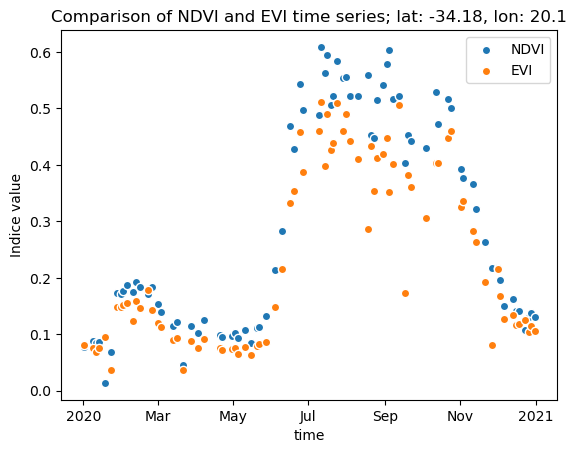

In [15]:
pt = (20.1, -34.18)
ndvi_pt = ndvi.sel(longitude=pt[0], latitude=pt[1], method="nearest")
evi_pt = evi.sel(longitude=pt[0], latitude=pt[1], method="nearest")

ndvi_pt.plot.scatter(x="time", label="NDVI")
evi_pt.plot.scatter(x="time", label="EVI")
plt.title(f"Comparison of NDVI and EVI time series; lat: {pt[1]}, lon: {pt[0]}")
plt.ylabel("Indice value")
plt.legend()